In [209]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests
import holidays

from pandas import CategoricalDtype
from bs4 import BeautifulSoup
from datetime import date
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid, GridSearchCV
from scipy import stats

import sys
import os

backend_path = os.path.abspath('../backend')
sys.path.append(backend_path)
from get_metrics import get_metrics



# Parcing data

In [210]:
# парсинг ключевой ставки в df
URL = 'https://www.cbr.ru/hd_base/keyrate/?UniDbQuery.Posted=True&UniDbQuery.From=17.09.2013&UniDbQuery.To=' + date.today().strftime('%d.%m.%Y')

data = requests.get(URL).text

bs4 = BeautifulSoup(data, "html.parser")
table = bs4.find_all("table")

df = pd.read_html(str(table))[0]
df.iloc[:,1:] /= 100

In [211]:
# преобразование столбца дата в формат datetime
df['Дата'] = pd.to_datetime(df['Дата'], dayfirst=True)

# перенаименование столбцов
df.columns = ['date', 'key_rate']

In [212]:
# общая информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2636 entries, 0 to 2635
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      2636 non-null   datetime64[ns]
 1   key_rate  2636 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 41.3 KB


In [213]:
# основные описательные статистики для числовых признаков
df.iloc[:, 1:].describe()

,key_rate
count,2636.000000
mean,8.710831
std,3.176341
min,4.250000
25%,7.000000
50%,7.750000
75%,10.500000
max,20.000000


In [214]:
df[:5]

,date,key_rate
0,2024-04-05,16.0
1,2024-04-04,16.0
2,2024-04-03,16.0
3,2024-04-02,16.0
4,2024-04-01,16.0


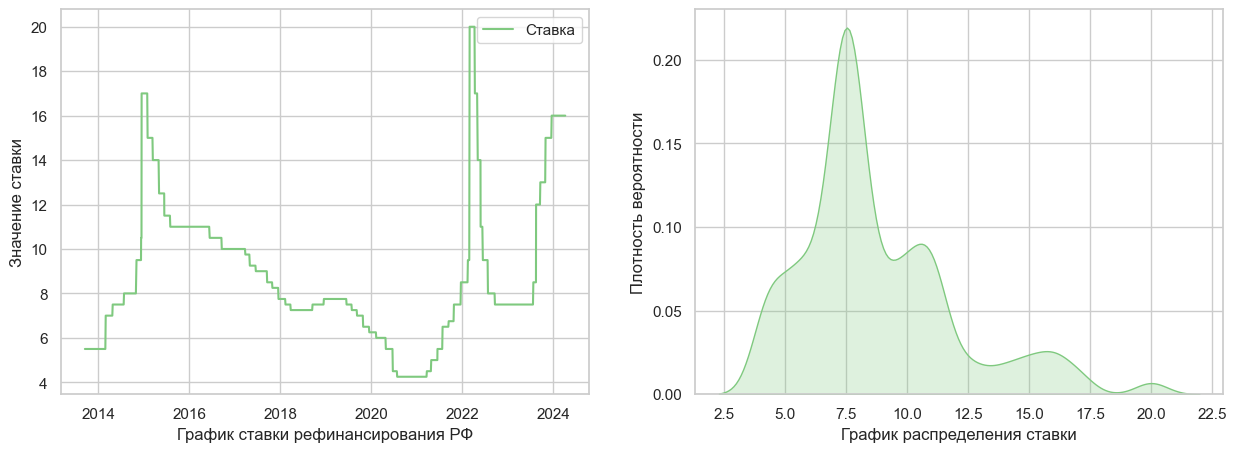

In [215]:
# рисуем график курса ключевой ствки ЦБ РФ и график распределения
figure, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.set_theme(style="whitegrid", palette="Accent")

sns.lineplot(x='date', y='key_rate', data=df, label='Ставка', ax=axes[0])
axes[0].set_xlabel('График ставки рефинансирования РФ')
axes[0].set_ylabel('Значение ставки')
axes[0].legend(loc='best')
axes[0].grid(True)

sns.kdeplot(x=df['key_rate'], ax=axes[1], fill=True)
axes[1].grid(True)
axes[1].set_xlabel('График распределения ставки')
axes[1].set_ylabel('Плотность вероятности')
plt.show()

# EDA

In [216]:
# проверка на нормальное или ненормальное распределение.
test_shapiro = stats.shapiro(df['key_rate'])

print(test_shapiro)

if test_shapiro.pvalue < 0.05:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')

ShapiroResult(statistic=0.903489351272583, pvalue=6.196024449851312e-38)
Распределение не нормальное


In [217]:
def create_features(data, col_datetime):
    """Создание сезонов и дней недели"""

    data = data.copy()
    data['weekday'] = data[col_datetime].dt.day_name().astype(cat_day)
    data['month'] = data[col_datetime].dt.month_name().astype(cat_month)
    data['year'] = data[col_datetime].dt.year
    data['quarter'] = data['date'].dt.quarter
    data['date_offset'] = (data[col_datetime].dt.month * 100 + data.date.dt.day - 320) % 1300
    data['season'] = data[col_datetime].dt.month.map({1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn', 11: 'Autumn', 12: 'Winter'})
    
    return data

cat_day = CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered= True)
cat_month = CategoricalDtype(categories=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], ordered= True)

df_features = create_features(data=df, col_datetime='date')

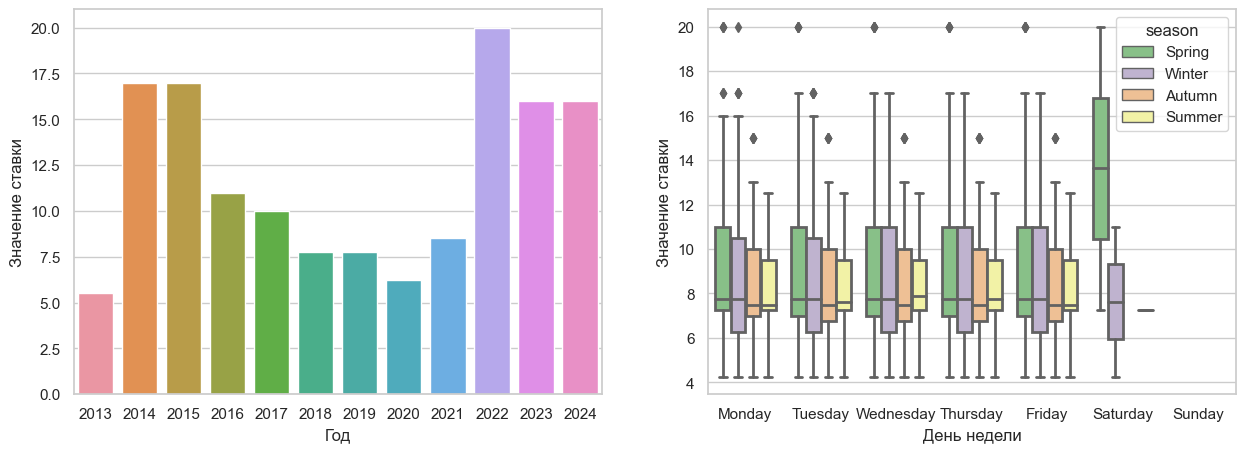

In [218]:
# рисуем графики для анализа
figure, axes = plt.subplots(1, 2, figsize=(15, 5))

year_group = pd.DataFrame(df_features.groupby('year')['key_rate'].max()).reset_index().sort_values('key_rate')

sns.barplot(data=year_group, x='year', y='key_rate', ax=axes[0])
axes[0].set_xlabel('Год')
axes[0].set_ylabel('Значение ставки')

sns.boxplot(data=df_features, x='weekday', y='key_rate', hue='season', ax=axes[1], linewidth=2)
axes[1].set_xlabel('День недели')
axes[1].set_ylabel('Значение ставки')

plt.show()



In [219]:
# дропаем редкие субботние ключевые ставки
drop_trash = df_features[(df_features.weekday == 'Saturday')].index
df = df[~df.index.isin(drop_trash)]
df = df.reset_index(drop=True)

In [220]:
# перенаименование названия колонок для prophet
df.columns = ['ds', 'y']

# период, который надо отрезать и предсказать (проверка модели)
pred_days = int(df.shape[0]*0.1)


In [221]:
# сортируем данные по возрастанию для корректного отображения разделения графика
df = df.sort_values('ds')
df = df.reset_index(drop=True)

In [222]:
# разделение данных на train, test
df_train = df[:-pred_days]
df_test = df[-pred_days:]


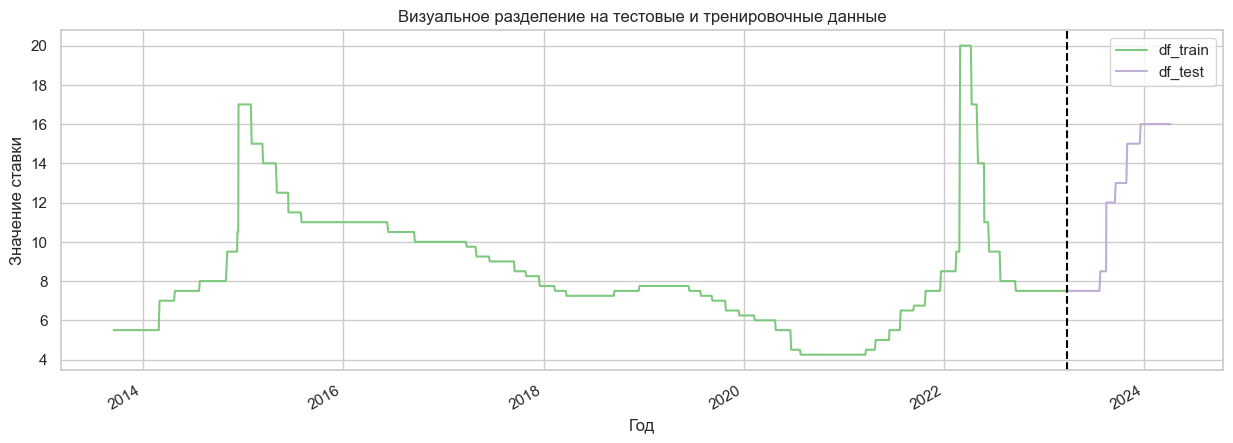

In [223]:
#отображаем график с разделением train, test для наглядности
fig, ax = plt.subplots(figsize = (10, 5))

fig.set_figheight(5)
fig.set_figwidth(15)
df_train.set_index('ds').plot(ax=ax, label= 'train', title='Визуальное разделение на тестовые и тренировочные данные')
df_test.set_index('ds').plot(ax=ax, label='test')
ax.axvline(df_train['ds'][-1:].values, ls='--', color='black')
ax.legend(['df_train', 'df_test'])
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

In [224]:
# обучение модели на train
model = Prophet()
model.fit(df_train)

01:18:31 - cmdstanpy - INFO - Chain [1] start processing
01:18:32 - cmdstanpy - INFO - Chain [1] done processing


In [225]:
future = model.make_future_dataframe(periods=pred_days, freq='D')
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2626,2023-12-08,11.775592,9.431086,14.462240
2627,2023-12-09,12.585713,10.369856,14.949046
2628,2023-12-10,12.635446,10.138862,15.009781
2629,2023-12-11,11.896726,9.409549,14.373994
2630,2023-12-12,11.953526,9.657027,14.319116


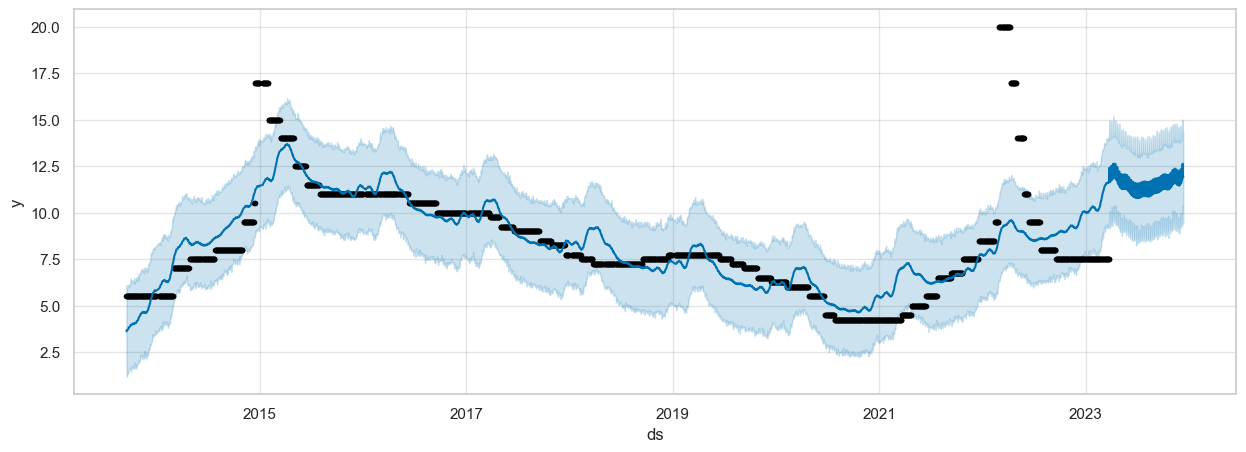

In [226]:
# смотрим график прогноза
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = model.plot(forecast,ax=ax)
plt.show()

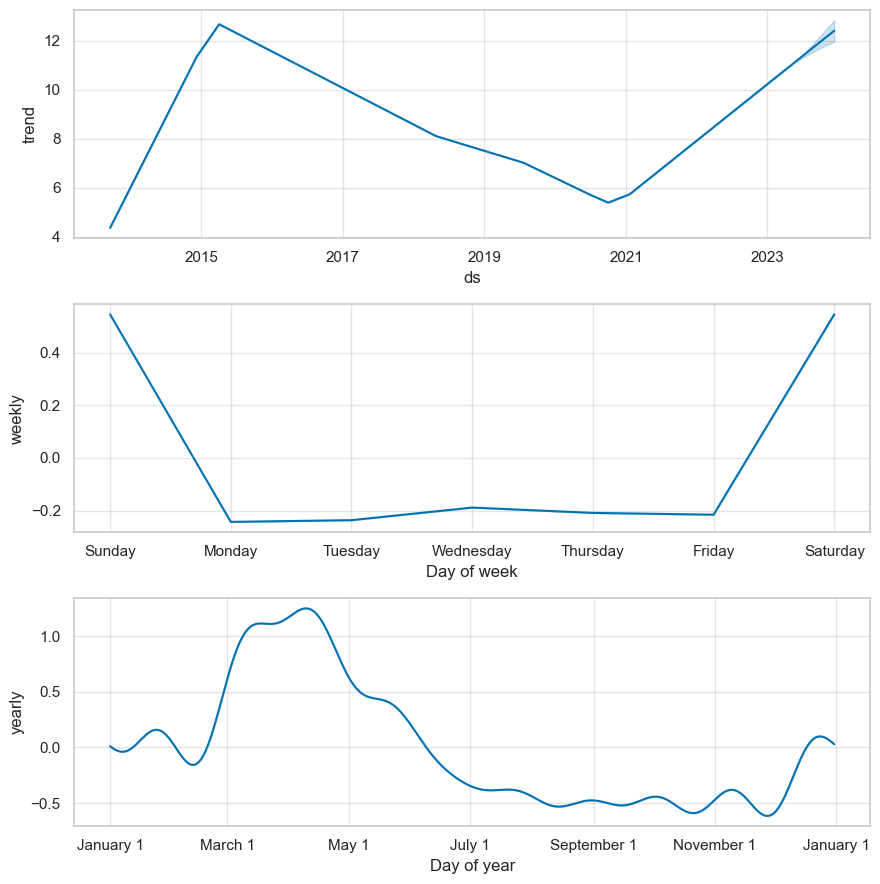

In [227]:
# смотрим тренд, годовые и сезонные признаки
fig = model.plot_components(forecast)
plt.show()

## Сравнение фактов и прогнозов

In [228]:
df_test_forecast = model.predict(df_test)
df_test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
258,2024-04-01,14.034320,11.483122,16.379954
259,2024-04-02,14.059922,11.627047,16.652743
260,2024-04-03,14.126794,11.668406,16.553786
261,2024-04-04,14.124895,11.461239,16.582967
262,2024-04-05,14.135389,11.612441,16.582466


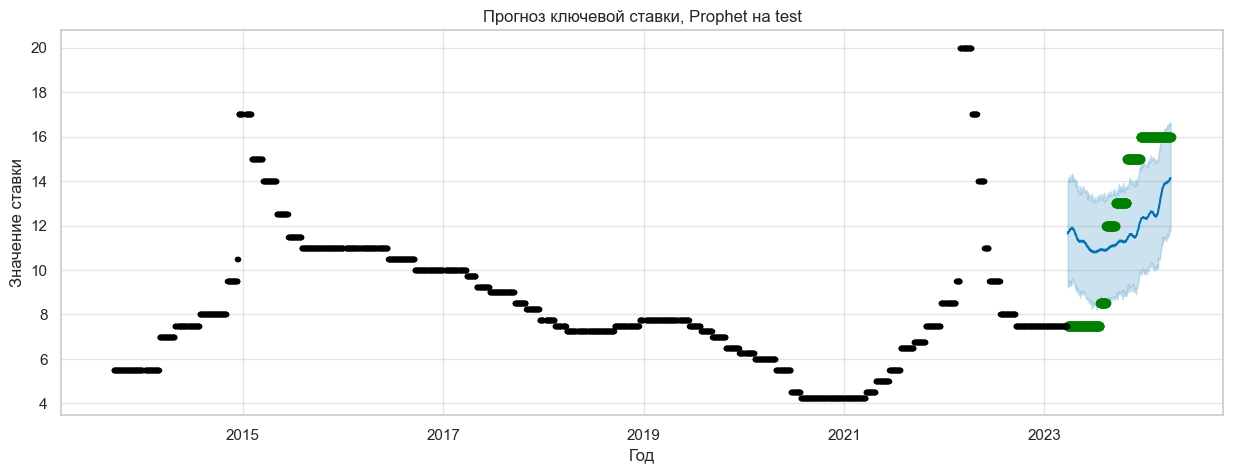

In [229]:
# смотрим совпадение фактического курса с предсказанным курсом prophet обученным на train, проверка модели
fig, ax = plt.subplots(figsize= (10, 5))

fig.set_figheight(5)
fig.set_figwidth(15)
predict = model.predict(df_test)
fig = model.plot(predict, ax=ax)
ax.scatter(df_test.ds, df_test['y'], color = 'g')
ax.set_title('Прогноз ключевой ставки, Prophet на test')
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

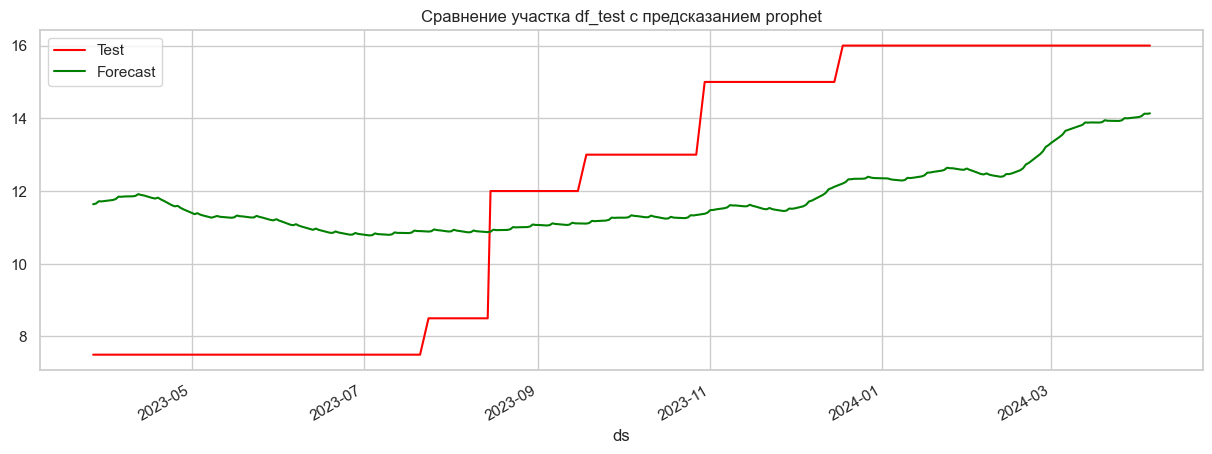

In [230]:
# сравнение участка df_test с предсказанием prophet
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet')
plt.show()

In [231]:
# просмотр метрик модели обученной на train в сравнени с прогнозом
metrics = get_metrics(y_test=df_test['y'], y_pred=df_test_forecast['yhat'], name='Prophet')
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet,2.933513,0.280977,9.560223,3.091961


Из приведенного выше графика мы видим, что существует разрыв в прогнозах и фактических данных. Поэтому нам нужно оптимизировать модель, добавив другие параметры, такие как праздники

In [232]:
# создаем df праздников в РФ начиная с 2013 по сегодня
holiday = pd.DataFrame([])
for date, name in sorted(holidays.Russia(years=[2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024]).items()):
    new_row = pd.DataFrame({'ds': date, 'holiday': "RU-Holidays"}, index=[0])
    holiday = pd.concat([holiday, new_row], ignore_index=True)  

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [233]:
# тренировка модели с праздниками
model_with_holidays = Prophet(holidays=holiday)
model_with_holidays.fit(df_train)

01:18:36 - cmdstanpy - INFO - Chain [1] start processing
01:18:37 - cmdstanpy - INFO - Chain [1] done processing


In [234]:
future = model_with_holidays.make_future_dataframe(periods=pred_days, freq='D')
forecast = model_with_holidays.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2626,2023-12-08,11.727308,9.470477,13.903891
2627,2023-12-09,12.537405,10.163865,15.035721
2628,2023-12-10,12.585744,10.531081,14.941968
2629,2023-12-11,11.839768,9.450486,14.325981
2630,2023-12-12,11.896646,9.746170,14.199719


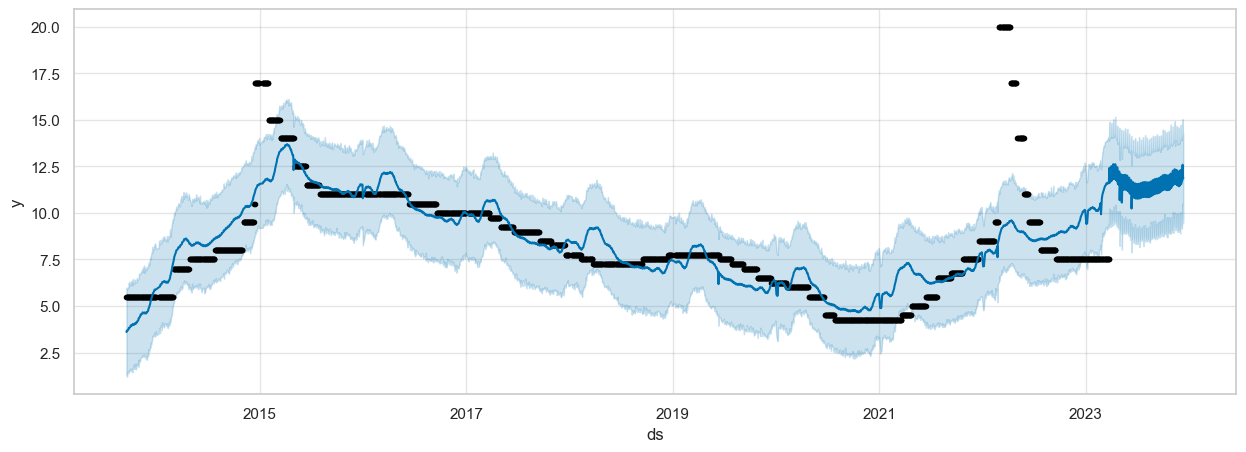

In [235]:
# смотрим график прогноза с праздниками
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = model_with_holidays.plot(forecast,ax=ax)
plt.show()

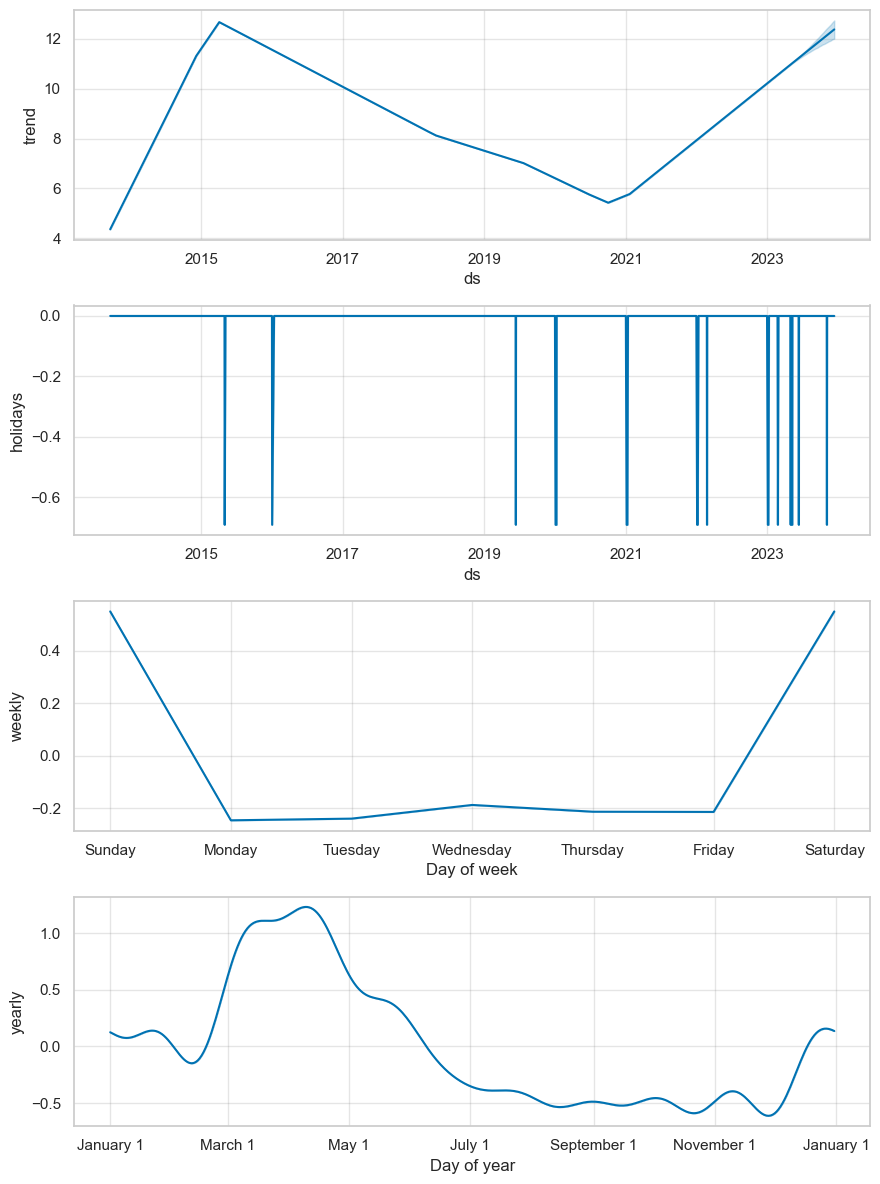

In [236]:
# смотрим тренд, годовые и сезонные признаки обученной модели с праздниками
fig = model_with_holidays.plot_components(forecast)
plt.show()

In [237]:
df_test_forecast_holiday = model_with_holidays.predict(df_test)
df_test_forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
258,2024-04-01,13.995771,11.373313,16.511404
259,2024-04-02,14.019589,11.574425,16.603258
260,2024-04-03,14.089046,11.639347,16.582864
261,2024-04-04,14.080160,11.619132,16.468794
262,2024-04-05,14.095332,11.485495,16.621964


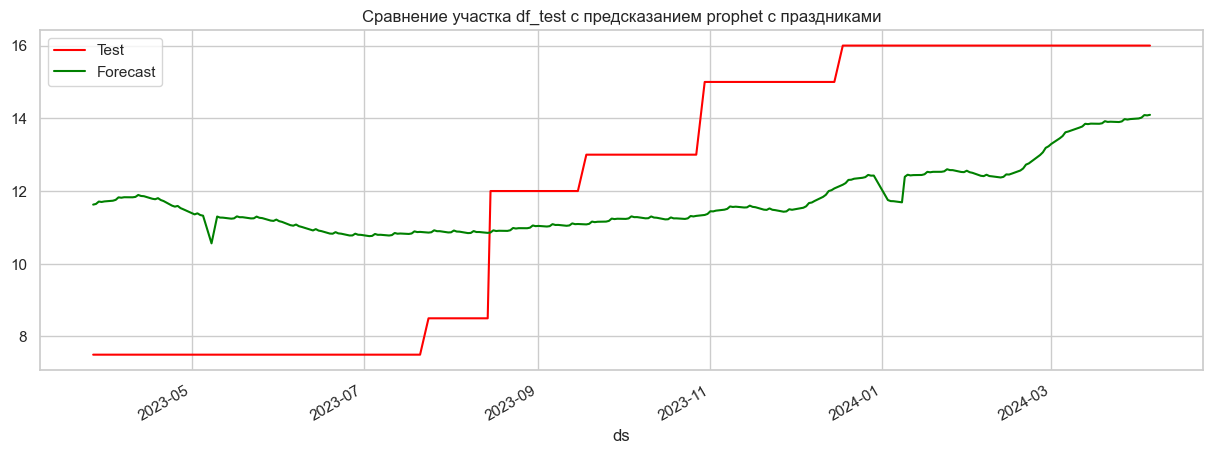

In [238]:
# сравнение участка df_test с предсказанием prophet
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast_holiday.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet с праздниками')
plt.show()

In [239]:
# сравниваем метрики после добавления в модель праздников 
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=df_test_forecast_holiday['yhat'], name='Prophet_with_holidays')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet,2.933513,0.280977,9.560223,3.091961
0,Prophet_with_holidays,2.947538,0.281309,9.635085,3.104043


Из метрик и графиков видим, что модель с праздниками показывает результаты немного хуже

## Тюнинг тест модели

In [240]:
# создание сетки параметров и подсчёт количества вариаций обучения
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.001, 0.01, 0.1, 0.5],
               'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
               'holidays_prior_scale':[0.01, 0.1, 1.0, 10.0],
               'n_changepoints' : [100, 150, 200]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Количество моделей для обучения по сетке:', cnt)

Количество моделей для обучения по сетке: 384


In [241]:
# Создаем пустой DataFrame с указанными столбцами
model_parameters = pd.DataFrame(columns=['MAPE', 'Parameters'])

# Проходимся по сетке гиперпараметров
for p in grid:
    print(p)
    
    # Создаем модель Prophet с текущими гиперпараметрами
    model_grid = Prophet(
        changepoint_prior_scale=p['changepoint_prior_scale'],
        seasonality_prior_scale=p['seasonality_prior_scale'],
        holidays_prior_scale=p['holidays_prior_scale'],
        n_changepoints=p['n_changepoints'],
        seasonality_mode=p['seasonality_mode'],
        weekly_seasonality=True,
        daily_seasonality=True,
        yearly_seasonality=True,
        holidays=holiday,
        interval_width=0.95
    )

    # Добавляем праздники в модель
    model_grid.add_country_holidays(country_name='RU')

    # Обучаем модель данными
    model_grid.fit(df_train)

    # Создаем фрейм данных для предсказаний
    model_grid_future = model_grid.make_future_dataframe(periods=pred_days, freq='D', include_history=False)

    # Делаем предсказания
    model_grid_forecast = model_grid.predict(model_grid_future)

    # Вычисляем MAPE
    MAPE = mean_absolute_percentage_error(df_test['y'], model_grid_forecast['yhat'])
    print('Mean Absolute Percentage Error(MAPE) - ', MAPE)

    # Добавляем новую строку в DataFrame
    model_parameters = pd.concat([model_parameters, pd.DataFrame({'MAPE': [MAPE], 'Parameters': [p]})], ignore_index=True)

{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:18:41 - cmdstanpy - INFO - Chain [1] start processing
01:18:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3555156723633367
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:18:42 - cmdstanpy - INFO - Chain [1] start processing
01:18:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.37437777185251436
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:18:44 - cmdstanpy - INFO - Chain [1] start processing
01:18:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.37291135837930517
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:18:45 - cmdstanpy - INFO - Chain [1] start processing
01:18:46 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.36987277243247024
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:18:47 - cmdstanpy - INFO - Chain [1] start processing
01:18:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3548687830738458
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:18:48 - cmdstanpy - INFO - Chain [1] start processing
01:18:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.36374362548796446
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:18:49 - cmdstanpy - INFO - Chain [1] start processing
01:18:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3649019142745044
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:18:51 - cmdstanpy - INFO - Chain [1] start processing
01:18:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3654586361668952
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:18:52 - cmdstanpy - INFO - Chain [1] start processing
01:18:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3399232307864872
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:18:54 - cmdstanpy - INFO - Chain [1] start processing
01:18:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.37527691842689254
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:18:55 - cmdstanpy - INFO - Chain [1] start processing
01:18:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.36932526775036273
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:18:57 - cmdstanpy - INFO - Chain [1] start processing
01:18:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.36363186211738663
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:19:00 - cmdstanpy - INFO - Chain [1] start processing
01:19:01 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.35737287231329995
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:19:02 - cmdstanpy - INFO - Chain [1] start processing
01:19:03 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3836456600961739
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:19:03 - cmdstanpy - INFO - Chain [1] start processing
01:19:05 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.36816990240553743
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:19:05 - cmdstanpy - INFO - Chain [1] start processing
01:19:06 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3656466004278528
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:19:07 - cmdstanpy - INFO - Chain [1] start processing
01:19:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.34721865321670997
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:19:10 - cmdstanpy - INFO - Chain [1] start processing
01:19:11 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3720591917521367
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:19:12 - cmdstanpy - INFO - Chain [1] start processing
01:19:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.375397312672488
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:19:15 - cmdstanpy - INFO - Chain [1] start processing
01:19:16 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.37824015693255475
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:19:17 - cmdstanpy - INFO - Chain [1] start processing
01:19:18 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3555797543085309
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:19:19 - cmdstanpy - INFO - Chain [1] start processing
01:19:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.36075926539948855
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:19:21 - cmdstanpy - INFO - Chain [1] start processing
01:19:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.37303488726849654
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:19:24 - cmdstanpy - INFO - Chain [1] start processing
01:19:26 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3817164783383589
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:19:26 - cmdstanpy - INFO - Chain [1] start processing
01:19:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3528413984381438
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:19:28 - cmdstanpy - INFO - Chain [1] start processing
01:19:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.36749210862321335
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:19:31 - cmdstanpy - INFO - Chain [1] start processing
01:19:33 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3790155470237297
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:19:34 - cmdstanpy - INFO - Chain [1] start processing
01:19:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3768118065965067
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:19:35 - cmdstanpy - INFO - Chain [1] start processing
01:19:37 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.36177002896571786
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:19:37 - cmdstanpy - INFO - Chain [1] start processing
01:19:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.36420946102909324
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:19:40 - cmdstanpy - INFO - Chain [1] start processing
01:19:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.36515207413065487
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:19:42 - cmdstanpy - INFO - Chain [1] start processing
01:19:42 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3658461783442435
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:19:43 - cmdstanpy - INFO - Chain [1] start processing
01:19:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.34603898664974964
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:19:48 - cmdstanpy - INFO - Chain [1] start processing
01:19:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.37354000313606944
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:19:50 - cmdstanpy - INFO - Chain [1] start processing
01:19:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3775982296699883
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:19:51 - cmdstanpy - INFO - Chain [1] start processing
01:19:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.37538592459501563
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:19:53 - cmdstanpy - INFO - Chain [1] start processing
01:19:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3584298095678312
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:19:54 - cmdstanpy - INFO - Chain [1] start processing
01:19:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3662768440237209
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:19:56 - cmdstanpy - INFO - Chain [1] start processing
01:19:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3870181534788362
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:19:58 - cmdstanpy - INFO - Chain [1] start processing
01:19:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3797728168171465
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:19:59 - cmdstanpy - INFO - Chain [1] start processing
01:20:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3537722333012028
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:20:01 - cmdstanpy - INFO - Chain [1] start processing
01:20:02 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.37019413570080323
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:20:03 - cmdstanpy - INFO - Chain [1] start processing
01:20:03 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.36482975756340114
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:20:04 - cmdstanpy - INFO - Chain [1] start processing
01:20:05 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3775915435572782
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:20:06 - cmdstanpy - INFO - Chain [1] start processing
01:20:07 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3614083618206786
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:20:07 - cmdstanpy - INFO - Chain [1] start processing
01:20:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.37533168397803096
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:20:10 - cmdstanpy - INFO - Chain [1] start processing
01:20:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.38310905884445323
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:20:13 - cmdstanpy - INFO - Chain [1] start processing
01:20:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.37137647209293495
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:20:15 - cmdstanpy - INFO - Chain [1] start processing
01:20:16 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3573214393987938
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:20:16 - cmdstanpy - INFO - Chain [1] start processing
01:20:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.36511699457094243
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:20:18 - cmdstanpy - INFO - Chain [1] start processing
01:20:18 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.37911724616729064
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:20:19 - cmdstanpy - INFO - Chain [1] start processing
01:20:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3771201619294903
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:20:20 - cmdstanpy - INFO - Chain [1] start processing
01:20:21 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3558202774753844
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:20:22 - cmdstanpy - INFO - Chain [1] start processing
01:20:22 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3636495650266401
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:20:23 - cmdstanpy - INFO - Chain [1] start processing
01:20:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.36841132851551306
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:20:24 - cmdstanpy - INFO - Chain [1] start processing
01:20:24 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3642425432168123
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:20:25 - cmdstanpy - INFO - Chain [1] start processing
01:20:26 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.355643621477759
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:20:27 - cmdstanpy - INFO - Chain [1] start processing
01:20:28 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3809956164637335
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:20:28 - cmdstanpy - INFO - Chain [1] start processing
01:20:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3688957461500034
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:20:30 - cmdstanpy - INFO - Chain [1] start processing
01:20:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.37215735262639826
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:20:32 - cmdstanpy - INFO - Chain [1] start processing
01:20:33 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3559682805827704
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:20:33 - cmdstanpy - INFO - Chain [1] start processing
01:20:34 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.37695131586414676
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:20:35 - cmdstanpy - INFO - Chain [1] start processing
01:20:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.38344882179640305
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:20:36 - cmdstanpy - INFO - Chain [1] start processing
01:20:37 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.38087571896672395
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:20:37 - cmdstanpy - INFO - Chain [1] start processing
01:20:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3587416722186922
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:20:39 - cmdstanpy - INFO - Chain [1] start processing
01:20:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3785945556035897
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:20:41 - cmdstanpy - INFO - Chain [1] start processing
01:20:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.35701313729854706
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:20:44 - cmdstanpy - INFO - Chain [1] start processing
01:20:46 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.36610822506831425
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:20:46 - cmdstanpy - INFO - Chain [1] start processing
01:20:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3583403180093871
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:20:48 - cmdstanpy - INFO - Chain [1] start processing
01:20:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.358960407129983
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:20:49 - cmdstanpy - INFO - Chain [1] start processing
01:20:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.36324875509938626
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:20:52 - cmdstanpy - INFO - Chain [1] start processing
01:20:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.37218619317157725
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10.0, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:20:55 - cmdstanpy - INFO - Chain [1] start processing
01:20:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.35898723056581616
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10.0, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:20:56 - cmdstanpy - INFO - Chain [1] start processing
01:20:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.37547358493737737
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10.0, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:20:57 - cmdstanpy - INFO - Chain [1] start processing
01:20:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.374857878187706
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10.0, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:20:58 - cmdstanpy - INFO - Chain [1] start processing
01:20:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.37261751878229743
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10.0, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:21:00 - cmdstanpy - INFO - Chain [1] start processing
01:21:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.357766920296715
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10.0, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:21:01 - cmdstanpy - INFO - Chain [1] start processing
01:21:01 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3652115922092623
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10.0, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:21:02 - cmdstanpy - INFO - Chain [1] start processing
01:21:03 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.37465645936255476
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10.0, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:21:03 - cmdstanpy - INFO - Chain [1] start processing
01:21:04 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.36452590146886005
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10.0, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:21:05 - cmdstanpy - INFO - Chain [1] start processing
01:21:06 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.35380947115038985
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10.0, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:21:06 - cmdstanpy - INFO - Chain [1] start processing
01:21:07 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3794663954991716
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10.0, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:21:08 - cmdstanpy - INFO - Chain [1] start processing
01:21:08 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.37759455216531074
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10.0, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:21:09 - cmdstanpy - INFO - Chain [1] start processing
01:21:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3717690711975794
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10.0, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:21:10 - cmdstanpy - INFO - Chain [1] start processing
01:21:11 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3611507404149278
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10.0, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:21:12 - cmdstanpy - INFO - Chain [1] start processing
01:21:13 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3695232007069879
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10.0, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:21:13 - cmdstanpy - INFO - Chain [1] start processing
01:21:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.36749701030453286
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10.0, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:21:15 - cmdstanpy - INFO - Chain [1] start processing
01:21:16 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3802754698641063
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10.0, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:21:17 - cmdstanpy - INFO - Chain [1] start processing
01:21:18 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.35565749780119976
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10.0, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:21:18 - cmdstanpy - INFO - Chain [1] start processing
01:21:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.38031330502014143
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10.0, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:21:20 - cmdstanpy - INFO - Chain [1] start processing
01:21:21 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.37033602895652135
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10.0, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:21:22 - cmdstanpy - INFO - Chain [1] start processing
01:21:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.37367136748380436
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10.0, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:21:26 - cmdstanpy - INFO - Chain [1] start processing
01:21:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3733460963748607
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10.0, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:21:28 - cmdstanpy - INFO - Chain [1] start processing
01:21:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.35906213743292614
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10.0, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:21:30 - cmdstanpy - INFO - Chain [1] start processing
01:21:32 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3667112373842745
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10.0, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:21:33 - cmdstanpy - INFO - Chain [1] start processing
01:21:34 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.37036129422447084
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:21:35 - cmdstanpy - INFO - Chain [1] start processing
01:21:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.32298356296291286
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:21:36 - cmdstanpy - INFO - Chain [1] start processing
01:21:37 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.34269401976235925
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:21:38 - cmdstanpy - INFO - Chain [1] start processing
01:21:39 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3438314481453352
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:21:40 - cmdstanpy - INFO - Chain [1] start processing
01:21:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3441253018838941
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:21:42 - cmdstanpy - INFO - Chain [1] start processing
01:21:42 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3280994231602795
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:21:43 - cmdstanpy - INFO - Chain [1] start processing
01:21:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3310762267901216
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:21:45 - cmdstanpy - INFO - Chain [1] start processing
01:21:45 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33165183575279517
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:21:46 - cmdstanpy - INFO - Chain [1] start processing
01:21:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3315554977944311
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:21:48 - cmdstanpy - INFO - Chain [1] start processing
01:21:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3227148222123963
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:21:50 - cmdstanpy - INFO - Chain [1] start processing
01:21:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.342080876481045
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:21:52 - cmdstanpy - INFO - Chain [1] start processing
01:21:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.34370568933013035
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:21:56 - cmdstanpy - INFO - Chain [1] start processing
01:21:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.34370786093609934
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:21:58 - cmdstanpy - INFO - Chain [1] start processing
01:21:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.32766895208054264
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:22:00 - cmdstanpy - INFO - Chain [1] start processing
01:22:02 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3308916845003176
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:22:03 - cmdstanpy - INFO - Chain [1] start processing
01:22:04 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3310228386955918
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:22:05 - cmdstanpy - INFO - Chain [1] start processing
01:22:06 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33156999189971226
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:22:07 - cmdstanpy - INFO - Chain [1] start processing
01:22:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.32254515721758714
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:22:10 - cmdstanpy - INFO - Chain [1] start processing
01:22:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.34228800270216264
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:22:15 - cmdstanpy - INFO - Chain [1] start processing
01:22:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.34384458143167645
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:22:18 - cmdstanpy - INFO - Chain [1] start processing
01:22:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.34327839289325257
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:22:21 - cmdstanpy - INFO - Chain [1] start processing
01:22:22 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.32770878839122125
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:22:23 - cmdstanpy - INFO - Chain [1] start processing
01:22:24 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3311954038520224
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:22:25 - cmdstanpy - INFO - Chain [1] start processing
01:22:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33167924836550106
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:22:28 - cmdstanpy - INFO - Chain [1] start processing
01:22:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33135934487837987
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:22:30 - cmdstanpy - INFO - Chain [1] start processing
01:22:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3228324894373691
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:22:31 - cmdstanpy - INFO - Chain [1] start processing
01:22:32 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3412149801846272
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:22:33 - cmdstanpy - INFO - Chain [1] start processing
01:22:34 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.34401547731036536
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:22:35 - cmdstanpy - INFO - Chain [1] start processing
01:22:37 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3439636232234434
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:22:37 - cmdstanpy - INFO - Chain [1] start processing
01:22:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3291521736012487
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:22:39 - cmdstanpy - INFO - Chain [1] start processing
01:22:39 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33272582557749714
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:22:40 - cmdstanpy - INFO - Chain [1] start processing
01:22:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3325367874852576
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:22:42 - cmdstanpy - INFO - Chain [1] start processing
01:22:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33261223738537044
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:22:43 - cmdstanpy - INFO - Chain [1] start processing
01:22:45 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3227821904054096
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:22:45 - cmdstanpy - INFO - Chain [1] start processing
01:22:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3422143154969797
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:22:48 - cmdstanpy - INFO - Chain [1] start processing
01:22:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.34406689218755687
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:22:50 - cmdstanpy - INFO - Chain [1] start processing
01:22:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3435518881979357
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:22:52 - cmdstanpy - INFO - Chain [1] start processing
01:22:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.32921757335067403
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:22:54 - cmdstanpy - INFO - Chain [1] start processing
01:22:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.332654401758139
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:22:56 - cmdstanpy - INFO - Chain [1] start processing
01:22:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3322140347107096
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:22:58 - cmdstanpy - INFO - Chain [1] start processing
01:22:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33293685306338655
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:23:00 - cmdstanpy - INFO - Chain [1] start processing
01:23:01 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3224328604730199
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:23:02 - cmdstanpy - INFO - Chain [1] start processing
01:23:04 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3421724905277105
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:23:05 - cmdstanpy - INFO - Chain [1] start processing
01:23:08 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3437678702158055
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:23:09 - cmdstanpy - INFO - Chain [1] start processing
01:23:11 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3438846055183834
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:23:12 - cmdstanpy - INFO - Chain [1] start processing
01:23:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.32859787653620953
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:23:14 - cmdstanpy - INFO - Chain [1] start processing
01:23:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33277278493714085
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:23:16 - cmdstanpy - INFO - Chain [1] start processing
01:23:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33264047191837404
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:23:19 - cmdstanpy - INFO - Chain [1] start processing
01:23:22 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33224045072040953
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:23:22 - cmdstanpy - INFO - Chain [1] start processing
01:23:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3225928126495785
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:23:24 - cmdstanpy - INFO - Chain [1] start processing
01:23:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.34201636473354874
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:23:25 - cmdstanpy - INFO - Chain [1] start processing
01:23:28 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3448181301080062
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:23:28 - cmdstanpy - INFO - Chain [1] start processing
01:23:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3437749647901039
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:23:30 - cmdstanpy - INFO - Chain [1] start processing
01:23:32 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.32959780694875096
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:23:32 - cmdstanpy - INFO - Chain [1] start processing
01:23:33 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33354492961766496
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:23:34 - cmdstanpy - INFO - Chain [1] start processing
01:23:34 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3334451802189193
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:23:35 - cmdstanpy - INFO - Chain [1] start processing
01:23:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.333348392456756
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:23:37 - cmdstanpy - INFO - Chain [1] start processing
01:23:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.322607876604114
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:23:38 - cmdstanpy - INFO - Chain [1] start processing
01:23:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.34233956838131907
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:23:41 - cmdstanpy - INFO - Chain [1] start processing
01:23:42 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.34361061671331056
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:23:43 - cmdstanpy - INFO - Chain [1] start processing
01:23:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.34393758980868244
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:23:45 - cmdstanpy - INFO - Chain [1] start processing
01:23:46 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3300528607388292
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:23:47 - cmdstanpy - INFO - Chain [1] start processing
01:23:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3319605936231998
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:23:50 - cmdstanpy - INFO - Chain [1] start processing
01:23:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3336224074894472
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:23:51 - cmdstanpy - INFO - Chain [1] start processing
01:23:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3333754744315682
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:23:53 - cmdstanpy - INFO - Chain [1] start processing
01:23:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3224652958305942
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:23:55 - cmdstanpy - INFO - Chain [1] start processing
01:23:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.342271578761534
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:23:59 - cmdstanpy - INFO - Chain [1] start processing
01:24:01 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.34369741011691535
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:24:02 - cmdstanpy - INFO - Chain [1] start processing
01:24:05 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.34362027994894817
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:24:06 - cmdstanpy - INFO - Chain [1] start processing
01:24:07 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33017907375525907
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:24:08 - cmdstanpy - INFO - Chain [1] start processing
01:24:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3326350730262544
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:24:10 - cmdstanpy - INFO - Chain [1] start processing
01:24:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33339025009218887
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:24:13 - cmdstanpy - INFO - Chain [1] start processing
01:24:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3336123383159597
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:24:15 - cmdstanpy - INFO - Chain [1] start processing
01:24:16 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3227964627179513
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:24:16 - cmdstanpy - INFO - Chain [1] start processing
01:24:18 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.34256889594091494
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:24:18 - cmdstanpy - INFO - Chain [1] start processing
01:24:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.34383686423884374
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:24:21 - cmdstanpy - INFO - Chain [1] start processing
01:24:22 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3443175878997844
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:24:23 - cmdstanpy - INFO - Chain [1] start processing
01:24:24 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3295316636572052
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:24:25 - cmdstanpy - INFO - Chain [1] start processing
01:24:26 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3335125315486199
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:24:27 - cmdstanpy - INFO - Chain [1] start processing
01:24:28 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33322863840559913
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:24:28 - cmdstanpy - INFO - Chain [1] start processing
01:24:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3335222108763948
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:24:30 - cmdstanpy - INFO - Chain [1] start processing
01:24:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.32298709220298083
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:24:32 - cmdstanpy - INFO - Chain [1] start processing
01:24:34 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.34323647175438327
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:24:34 - cmdstanpy - INFO - Chain [1] start processing
01:24:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3433758452332957
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:24:37 - cmdstanpy - INFO - Chain [1] start processing
01:24:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.34377106454569756
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:24:41 - cmdstanpy - INFO - Chain [1] start processing
01:24:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3300402761037007
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:24:42 - cmdstanpy - INFO - Chain [1] start processing
01:24:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3335895649168846
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:24:45 - cmdstanpy - INFO - Chain [1] start processing
01:24:46 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33341557766152663
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:24:47 - cmdstanpy - INFO - Chain [1] start processing
01:24:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3333125361799971
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:24:49 - cmdstanpy - INFO - Chain [1] start processing
01:24:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.32244491014210147
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:24:52 - cmdstanpy - INFO - Chain [1] start processing
01:24:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.34227067590912447
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:24:55 - cmdstanpy - INFO - Chain [1] start processing
01:24:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3440927884783823
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:24:58 - cmdstanpy - INFO - Chain [1] start processing
01:25:01 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3439012238378399
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:25:02 - cmdstanpy - INFO - Chain [1] start processing
01:25:03 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3300677083847377
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:25:04 - cmdstanpy - INFO - Chain [1] start processing
01:25:06 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33327324898280036
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:25:06 - cmdstanpy - INFO - Chain [1] start processing
01:25:08 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3328916070696281
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:25:09 - cmdstanpy - INFO - Chain [1] start processing
01:25:11 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33292976700449917
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:25:12 - cmdstanpy - INFO - Chain [1] start processing
01:25:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33041393818123777
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:25:16 - cmdstanpy - INFO - Chain [1] start processing
01:25:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3536455014036672
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:25:24 - cmdstanpy - INFO - Chain [1] start processing
01:25:45 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5162688382888532
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:25:46 - cmdstanpy - INFO - Chain [1] start processing
01:26:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.508601505510285
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:26:01 - cmdstanpy - INFO - Chain [1] start processing
01:26:04 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.32626645954446415
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:26:05 - cmdstanpy - INFO - Chain [1] start processing
01:26:08 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.32925489476298675
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:26:09 - cmdstanpy - INFO - Chain [1] start processing
01:26:11 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3294966468682213
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:26:12 - cmdstanpy - INFO - Chain [1] start processing
01:26:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3294420702280845
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:26:15 - cmdstanpy - INFO - Chain [1] start processing
01:26:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3306243840274473
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:26:19 - cmdstanpy - INFO - Chain [1] start processing
01:26:28 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.353767721686245
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:26:29 - cmdstanpy - INFO - Chain [1] start processing
01:26:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5127883114923003
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:26:44 - cmdstanpy - INFO - Chain [1] start processing
01:26:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5065783647535189
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:27:00 - cmdstanpy - INFO - Chain [1] start processing
01:27:02 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.32657496702061123
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:27:03 - cmdstanpy - INFO - Chain [1] start processing
01:27:06 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3296543231799497
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:27:07 - cmdstanpy - INFO - Chain [1] start processing
01:27:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3293802646474085
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:27:10 - cmdstanpy - INFO - Chain [1] start processing
01:27:13 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3297327915467861
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:27:14 - cmdstanpy - INFO - Chain [1] start processing
01:27:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33075940970580253
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:27:20 - cmdstanpy - INFO - Chain [1] start processing
01:27:32 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.35307098674707166
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:27:33 - cmdstanpy - INFO - Chain [1] start processing
01:27:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5156240798609092
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:27:55 - cmdstanpy - INFO - Chain [1] start processing
01:28:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5062931779427174
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:28:16 - cmdstanpy - INFO - Chain [1] start processing
01:28:21 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.32671780930387095
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:28:21 - cmdstanpy - INFO - Chain [1] start processing
01:28:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3298455347343096
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:28:26 - cmdstanpy - INFO - Chain [1] start processing
01:28:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.32973850823830536
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:28:31 - cmdstanpy - INFO - Chain [1] start processing
01:28:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3299347206393813
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:28:35 - cmdstanpy - INFO - Chain [1] start processing
01:28:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3302530755188388
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:28:39 - cmdstanpy - INFO - Chain [1] start processing
01:28:46 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.352954518172719
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:28:47 - cmdstanpy - INFO - Chain [1] start processing
01:29:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5104549718386348
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:29:01 - cmdstanpy - INFO - Chain [1] start processing
01:29:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5110915965080549
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:29:15 - cmdstanpy - INFO - Chain [1] start processing
01:29:18 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.32649120494724265
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:29:19 - cmdstanpy - INFO - Chain [1] start processing
01:29:22 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3295995984189345
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:29:23 - cmdstanpy - INFO - Chain [1] start processing
01:29:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3296619211241653
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:29:25 - cmdstanpy - INFO - Chain [1] start processing
01:29:28 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.32979525734844084
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:29:29 - cmdstanpy - INFO - Chain [1] start processing
01:29:32 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33036105898876933
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:29:33 - cmdstanpy - INFO - Chain [1] start processing
01:29:39 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3529147407015726
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:29:40 - cmdstanpy - INFO - Chain [1] start processing
01:29:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5006084577331613
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:29:55 - cmdstanpy - INFO - Chain [1] start processing
01:30:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.505675219175296
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:30:11 - cmdstanpy - INFO - Chain [1] start processing
01:30:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3267438543987934
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:30:15 - cmdstanpy - INFO - Chain [1] start processing
01:30:18 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.32989890354329304
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:30:19 - cmdstanpy - INFO - Chain [1] start processing
01:30:22 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.32995066713417176
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:30:23 - cmdstanpy - INFO - Chain [1] start processing
01:30:26 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3299230692152968
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:30:27 - cmdstanpy - INFO - Chain [1] start processing
01:30:32 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3305400505987663
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:30:33 - cmdstanpy - INFO - Chain [1] start processing
01:30:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3531274626800483
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:30:48 - cmdstanpy - INFO - Chain [1] start processing
01:31:07 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.49960027251450007
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:31:08 - cmdstanpy - INFO - Chain [1] start processing
01:31:32 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5028516675550818
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:31:32 - cmdstanpy - INFO - Chain [1] start processing
01:31:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.32692695486751455
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:31:37 - cmdstanpy - INFO - Chain [1] start processing
01:31:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33010452921684613
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:31:42 - cmdstanpy - INFO - Chain [1] start processing
01:31:45 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3298593021290643
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:31:46 - cmdstanpy - INFO - Chain [1] start processing
01:31:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33010020737683365
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:31:51 - cmdstanpy - INFO - Chain [1] start processing
01:31:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33103217057682355
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:31:55 - cmdstanpy - INFO - Chain [1] start processing
01:32:01 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3526503638081537
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:32:02 - cmdstanpy - INFO - Chain [1] start processing
01:32:16 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5079396222635552
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:32:17 - cmdstanpy - INFO - Chain [1] start processing
01:32:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5099384337702624
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:32:31 - cmdstanpy - INFO - Chain [1] start processing
01:32:33 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.32685867565162924
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:32:34 - cmdstanpy - INFO - Chain [1] start processing
01:32:37 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.32991199891386186
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:32:38 - cmdstanpy - INFO - Chain [1] start processing
01:32:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3300801035464108
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:32:41 - cmdstanpy - INFO - Chain [1] start processing
01:32:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3300115650327549
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:32:45 - cmdstanpy - INFO - Chain [1] start processing
01:32:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33121514295077437
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:32:48 - cmdstanpy - INFO - Chain [1] start processing
01:32:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3535002242350418
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:32:57 - cmdstanpy - INFO - Chain [1] start processing
01:33:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5122208856049394
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:33:12 - cmdstanpy - INFO - Chain [1] start processing
01:33:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5157134348113876
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:33:28 - cmdstanpy - INFO - Chain [1] start processing
01:33:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.32714448267039314
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:33:32 - cmdstanpy - INFO - Chain [1] start processing
01:33:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33028639953672906
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:33:36 - cmdstanpy - INFO - Chain [1] start processing
01:33:39 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3303624105758234
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:33:40 - cmdstanpy - INFO - Chain [1] start processing
01:33:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33041520207445885
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:33:44 - cmdstanpy - INFO - Chain [1] start processing
01:33:48 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3313303239738249
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:33:49 - cmdstanpy - INFO - Chain [1] start processing
01:33:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3525989477026971
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:33:58 - cmdstanpy - INFO - Chain [1] start processing
01:34:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5110690560108189
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:34:18 - cmdstanpy - INFO - Chain [1] start processing
01:34:37 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5102205223814836
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:34:38 - cmdstanpy - INFO - Chain [1] start processing
01:34:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.32728827698224483
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:34:45 - cmdstanpy - INFO - Chain [1] start processing
01:34:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33040206604289496
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:34:50 - cmdstanpy - INFO - Chain [1] start processing
01:34:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33047294147474704
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:34:55 - cmdstanpy - INFO - Chain [1] start processing
01:35:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33049643882981744
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:35:01 - cmdstanpy - INFO - Chain [1] start processing
01:35:04 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3311347888878204
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:35:05 - cmdstanpy - INFO - Chain [1] start processing
01:35:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3532726649842015
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:35:11 - cmdstanpy - INFO - Chain [1] start processing
01:35:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5090245434054782
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:35:26 - cmdstanpy - INFO - Chain [1] start processing
01:35:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5082051470354507
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:35:42 - cmdstanpy - INFO - Chain [1] start processing
01:35:45 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.32683732643353236
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:35:46 - cmdstanpy - INFO - Chain [1] start processing
01:35:48 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.32998072197771705
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:35:49 - cmdstanpy - INFO - Chain [1] start processing
01:35:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3300614036315014
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:35:52 - cmdstanpy - INFO - Chain [1] start processing
01:35:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33004657582841823
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:35:55 - cmdstanpy - INFO - Chain [1] start processing
01:35:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33121374705294776
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:35:59 - cmdstanpy - INFO - Chain [1] start processing
01:36:05 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.35315087712804827
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:36:06 - cmdstanpy - INFO - Chain [1] start processing
01:36:21 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5048821610819273
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:36:22 - cmdstanpy - INFO - Chain [1] start processing
01:36:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5040209358932161
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:36:37 - cmdstanpy - INFO - Chain [1] start processing
01:36:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.32719500575447646
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:36:41 - cmdstanpy - INFO - Chain [1] start processing
01:36:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33027780336586676
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:36:45 - cmdstanpy - INFO - Chain [1] start processing
01:36:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33033661603100395
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:36:48 - cmdstanpy - INFO - Chain [1] start processing
01:36:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33039792402148843
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:36:52 - cmdstanpy - INFO - Chain [1] start processing
01:36:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33150103970683925
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:36:59 - cmdstanpy - INFO - Chain [1] start processing
01:37:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3534798032292611
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:37:13 - cmdstanpy - INFO - Chain [1] start processing
01:37:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5030327756735311
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:37:32 - cmdstanpy - INFO - Chain [1] start processing
01:37:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.518843662963375
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:37:51 - cmdstanpy - INFO - Chain [1] start processing
01:37:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3273448257531053
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:37:56 - cmdstanpy - INFO - Chain [1] start processing
01:38:01 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3304262473286583
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:38:02 - cmdstanpy - INFO - Chain [1] start processing
01:38:06 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33055941533852173
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:38:07 - cmdstanpy - INFO - Chain [1] start processing
01:38:11 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3304649250367688
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:38:12 - cmdstanpy - INFO - Chain [1] start processing
01:38:22 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33931563665310654
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:38:23 - cmdstanpy - INFO - Chain [1] start processing
01:38:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5016409969206377
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:38:37 - cmdstanpy - INFO - Chain [1] start processing
01:38:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5362777222140704
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:38:50 - cmdstanpy - INFO - Chain [1] start processing
01:39:03 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5388088887801029
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:39:03 - cmdstanpy - INFO - Chain [1] start processing
01:39:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.34522569324864655
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:39:15 - cmdstanpy - INFO - Chain [1] start processing
01:39:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3593192850981416
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:39:28 - cmdstanpy - INFO - Chain [1] start processing
01:39:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3597295206985306
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:39:41 - cmdstanpy - INFO - Chain [1] start processing
01:39:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3591229017458882
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:39:54 - cmdstanpy - INFO - Chain [1] start processing
01:40:04 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33989990256040414
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:40:05 - cmdstanpy - INFO - Chain [1] start processing
01:40:21 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5099684870973129
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:40:22 - cmdstanpy - INFO - Chain [1] start processing
01:40:37 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5396044323563621
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:40:38 - cmdstanpy - INFO - Chain [1] start processing
01:40:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5477697316488551
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:40:55 - cmdstanpy - INFO - Chain [1] start processing
01:41:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.34623466508427103
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:41:11 - cmdstanpy - INFO - Chain [1] start processing
01:41:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3585998413418298
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:41:26 - cmdstanpy - INFO - Chain [1] start processing
01:41:37 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.35524469648396556
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:41:38 - cmdstanpy - INFO - Chain [1] start processing
01:41:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3554924365480939
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:41:54 - cmdstanpy - INFO - Chain [1] start processing
01:42:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.34011464335356534
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:42:15 - cmdstanpy - INFO - Chain [1] start processing
01:42:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5047846455057124
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:42:37 - cmdstanpy - INFO - Chain [1] start processing
01:42:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5442773362512088
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:42:59 - cmdstanpy - INFO - Chain [1] start processing
01:43:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.53473894513063
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:43:20 - cmdstanpy - INFO - Chain [1] start processing
01:43:39 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3471666993964515
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:43:40 - cmdstanpy - INFO - Chain [1] start processing
01:43:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3585260096049542
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:44:00 - cmdstanpy - INFO - Chain [1] start processing
01:44:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.35788444796683283
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:44:20 - cmdstanpy - INFO - Chain [1] start processing
01:44:39 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.35715085181222994
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:44:40 - cmdstanpy - INFO - Chain [1] start processing
01:44:48 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3388250865035972
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:44:49 - cmdstanpy - INFO - Chain [1] start processing
01:45:04 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5042756802891888
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:45:05 - cmdstanpy - INFO - Chain [1] start processing
01:45:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.535611967663777
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:45:21 - cmdstanpy - INFO - Chain [1] start processing
01:45:34 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5351674895115718
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:45:35 - cmdstanpy - INFO - Chain [1] start processing
01:45:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.34522487965449006
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:45:48 - cmdstanpy - INFO - Chain [1] start processing
01:45:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.35575771674800905
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:46:00 - cmdstanpy - INFO - Chain [1] start processing
01:46:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3540682445849516
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:46:11 - cmdstanpy - INFO - Chain [1] start processing
01:46:26 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3558932889808043
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:46:27 - cmdstanpy - INFO - Chain [1] start processing
01:46:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3402476552825161
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:46:39 - cmdstanpy - INFO - Chain [1] start processing
01:46:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5034835122649903
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:46:57 - cmdstanpy - INFO - Chain [1] start processing
01:47:13 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5415911306131364
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:47:14 - cmdstanpy - INFO - Chain [1] start processing
01:47:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5364955880989731
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:47:31 - cmdstanpy - INFO - Chain [1] start processing
01:47:46 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.34684650527078614
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:47:47 - cmdstanpy - INFO - Chain [1] start processing
01:48:02 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3552148132299482
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:48:03 - cmdstanpy - INFO - Chain [1] start processing
01:48:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3583618417890823
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:48:20 - cmdstanpy - INFO - Chain [1] start processing
01:48:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.35595598819664037
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:48:36 - cmdstanpy - INFO - Chain [1] start processing
01:48:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3398547606505922
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:48:57 - cmdstanpy - INFO - Chain [1] start processing
01:49:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5055959852574312
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:49:18 - cmdstanpy - INFO - Chain [1] start processing
01:49:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5365667484025587
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:49:41 - cmdstanpy - INFO - Chain [1] start processing
01:50:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5341346725559856
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:50:01 - cmdstanpy - INFO - Chain [1] start processing
01:50:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3456173516589512
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:50:24 - cmdstanpy - INFO - Chain [1] start processing
01:50:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.35835842408337315
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:50:49 - cmdstanpy - INFO - Chain [1] start processing
01:51:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.35640352906855977
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:51:18 - cmdstanpy - INFO - Chain [1] start processing
01:51:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3582073830670778
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 1.0, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:51:39 - cmdstanpy - INFO - Chain [1] start processing
01:51:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3405477247307403
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 1.0, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:51:52 - cmdstanpy - INFO - Chain [1] start processing
01:52:06 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5067311772298301
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 1.0, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:52:07 - cmdstanpy - INFO - Chain [1] start processing
01:52:21 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.534048945222069
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 1.0, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:52:22 - cmdstanpy - INFO - Chain [1] start processing
01:52:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5392078543053519
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 1.0, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:52:39 - cmdstanpy - INFO - Chain [1] start processing
01:52:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.34596405415216686
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 1.0, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:52:53 - cmdstanpy - INFO - Chain [1] start processing
01:52:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3503158876054315
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 1.0, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:52:59 - cmdstanpy - INFO - Chain [1] start processing
01:53:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3603418720922068
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 1.0, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:53:16 - cmdstanpy - INFO - Chain [1] start processing
01:53:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.36036178559369375
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 1.0, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:53:31 - cmdstanpy - INFO - Chain [1] start processing
01:53:45 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.34055678995535765
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 1.0, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:53:46 - cmdstanpy - INFO - Chain [1] start processing
01:54:05 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5050045064606048
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 1.0, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:54:06 - cmdstanpy - INFO - Chain [1] start processing
01:54:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5327225012232617
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 1.0, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:54:23 - cmdstanpy - INFO - Chain [1] start processing
01:54:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5457799685658664
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 1.0, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:54:41 - cmdstanpy - INFO - Chain [1] start processing
01:54:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.34615072492084464
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 1.0, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:54:58 - cmdstanpy - INFO - Chain [1] start processing
01:55:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3614057109654924
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 1.0, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:55:15 - cmdstanpy - INFO - Chain [1] start processing
01:55:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3582984801928345
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 1.0, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:55:32 - cmdstanpy - INFO - Chain [1] start processing
01:55:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3600423364071956
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 1.0, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:55:53 - cmdstanpy - INFO - Chain [1] start processing
01:56:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3414237262522432
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 1.0, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:56:15 - cmdstanpy - INFO - Chain [1] start processing
01:56:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5030240744231056
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 1.0, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:56:36 - cmdstanpy - INFO - Chain [1] start processing
01:56:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5317241837660055
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 1.0, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:56:59 - cmdstanpy - INFO - Chain [1] start processing
01:57:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5374987108393572
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 1.0, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:57:20 - cmdstanpy - INFO - Chain [1] start processing
01:57:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.34552817504170363
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 1.0, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:57:42 - cmdstanpy - INFO - Chain [1] start processing
01:58:02 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.35757755789685847
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 1.0, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:58:03 - cmdstanpy - INFO - Chain [1] start processing
01:58:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.35850526383368825
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 1.0, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:58:24 - cmdstanpy - INFO - Chain [1] start processing
01:58:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.35579624229316503
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10.0, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:58:45 - cmdstanpy - INFO - Chain [1] start processing
01:58:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.33970493950222963
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10.0, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:58:53 - cmdstanpy - INFO - Chain [1] start processing
01:59:08 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5053538518990909
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10.0, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:59:09 - cmdstanpy - INFO - Chain [1] start processing
01:59:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5356658083227391
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10.0, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:59:24 - cmdstanpy - INFO - Chain [1] start processing
01:59:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5400018663031035
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10.0, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:59:39 - cmdstanpy - INFO - Chain [1] start processing
01:59:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3466557053314885
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10.0, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:59:52 - cmdstanpy - INFO - Chain [1] start processing
02:00:06 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.36233017660191286
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10.0, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:00:07 - cmdstanpy - INFO - Chain [1] start processing
02:00:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3556652619745243
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10.0, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:00:19 - cmdstanpy - INFO - Chain [1] start processing
02:00:33 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.36180585172861535
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10.0, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:00:34 - cmdstanpy - INFO - Chain [1] start processing
02:00:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3407200536573028
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10.0, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:00:48 - cmdstanpy - INFO - Chain [1] start processing
02:01:04 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5054477574886922
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10.0, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:01:05 - cmdstanpy - INFO - Chain [1] start processing
02:01:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5402759135720978
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10.0, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:01:23 - cmdstanpy - INFO - Chain [1] start processing
02:01:39 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5438571926790099
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10.0, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:01:40 - cmdstanpy - INFO - Chain [1] start processing
02:01:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.34720470278461674
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10.0, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:01:57 - cmdstanpy - INFO - Chain [1] start processing
02:02:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3570799007303755
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10.0, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:02:13 - cmdstanpy - INFO - Chain [1] start processing
02:02:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3573943505510214
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10.0, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:02:28 - cmdstanpy - INFO - Chain [1] start processing
02:02:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.35874350252562254
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10.0, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:02:45 - cmdstanpy - INFO - Chain [1] start processing
02:03:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3398165184131323
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10.0, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:03:01 - cmdstanpy - INFO - Chain [1] start processing
02:03:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5089193830963419
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10.0, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:03:21 - cmdstanpy - INFO - Chain [1] start processing
02:03:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5339065262695408
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10.0, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:03:42 - cmdstanpy - INFO - Chain [1] start processing
02:04:01 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.5312728420257256
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10.0, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:04:02 - cmdstanpy - INFO - Chain [1] start processing
02:04:21 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.34634001186710556
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10.0, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:04:22 - cmdstanpy - INFO - Chain [1] start processing
02:04:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.35866168586810315
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10.0, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:04:41 - cmdstanpy - INFO - Chain [1] start processing
02:04:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3585788957856376
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10.0, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:05:00 - cmdstanpy - INFO - Chain [1] start processing
02:05:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE) -  0.3562303342913076


In [242]:
parameters = model_parameters.sort_values(by=['MAPE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

,MAPE,Parameters
0,0.322433,"{'changepoint_prior_scale': 0.01, 'holidays_pr..."
1,0.322445,"{'changepoint_prior_scale': 0.01, 'holidays_pr..."
2,0.322465,"{'changepoint_prior_scale': 0.01, 'holidays_pr..."
3,0.322545,"{'changepoint_prior_scale': 0.01, 'holidays_pr..."
4,0.322593,"{'changepoint_prior_scale': 0.01, 'holidays_pr..."


In [244]:
parameters['Parameters'][0]


{'changepoint_prior_scale': 0.01,
 'holidays_prior_scale': 0.1,
 'n_changepoints': 200,
 'seasonality_mode': 'multiplicative',
 'seasonality_prior_scale': 0.01}

In [246]:
final_test_model = Prophet(holidays=holiday,
                           changepoint_prior_scale = 0.01,
                           holidays_prior_scale = 0.1,
                           n_changepoints = 200,
                           seasonality_prior_scale = 0.01,
                           seasonality_mode = 'multiplicative',
                           weekly_seasonality = True,
                           daily_seasonality = True,
                           yearly_seasonality = True,
                           interval_width = 0.95)
final_test_model.add_country_holidays(country_name='RU')
final_test_model.fit(df_train)


02:09:43 - cmdstanpy - INFO - Chain [1] start processing
02:09:45 - cmdstanpy - INFO - Chain [1] done processing


In [247]:
future = final_test_model.make_future_dataframe(periods=pred_days, freq='D')
forecast = final_test_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2626,2023-12-08,11.062815,7.203295,14.722219
2627,2023-12-09,10.885872,6.935345,14.505789
2628,2023-12-10,10.936570,7.223434,14.604128
2629,2023-12-11,11.173134,7.358867,15.147705
2630,2023-12-12,11.246683,7.139688,15.114993


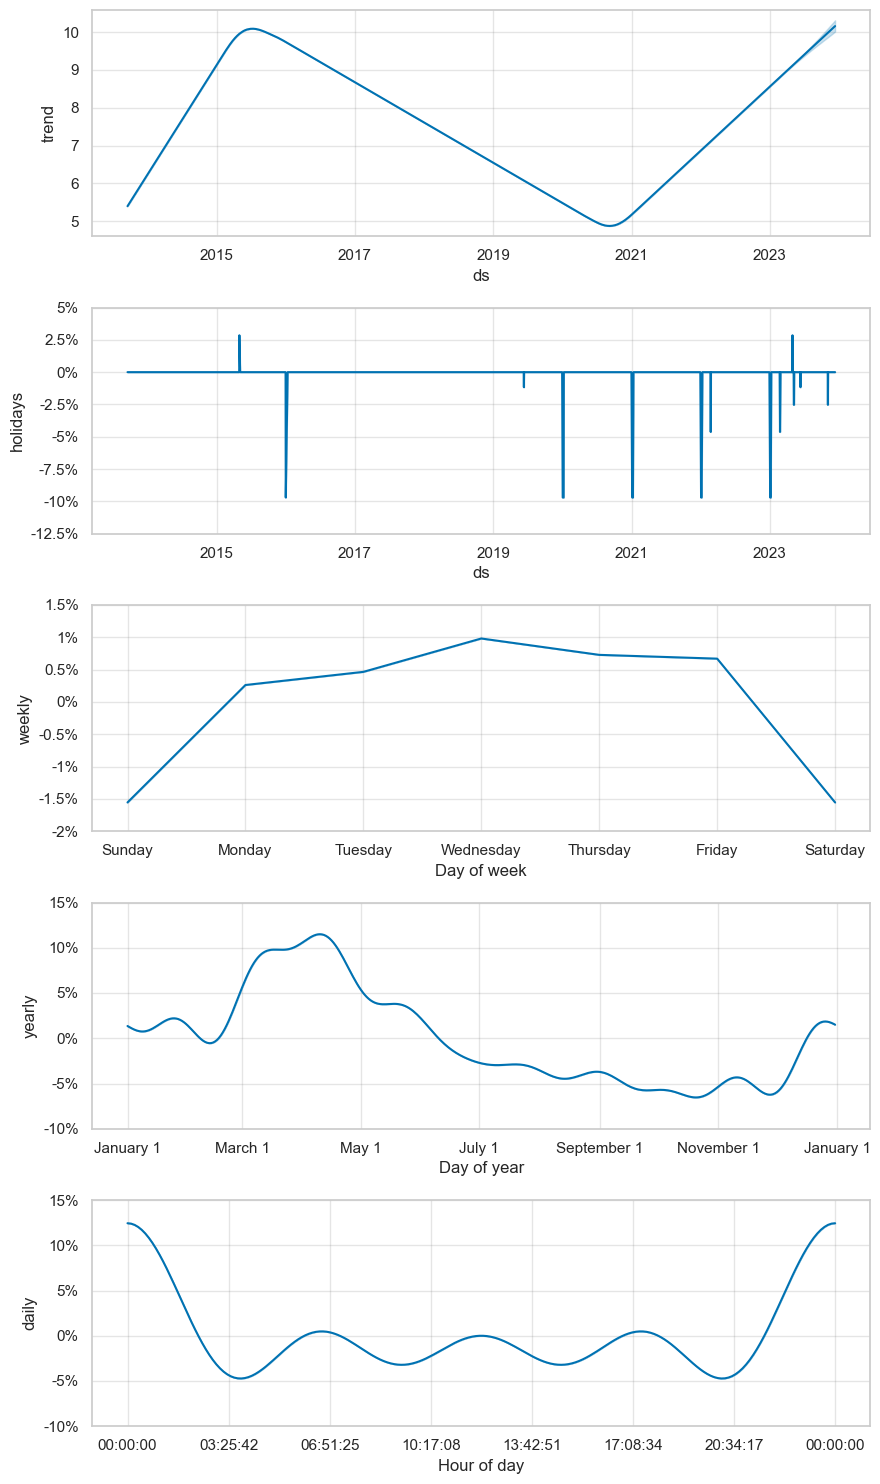

In [248]:
fig = final_test_model.plot_components(forecast)

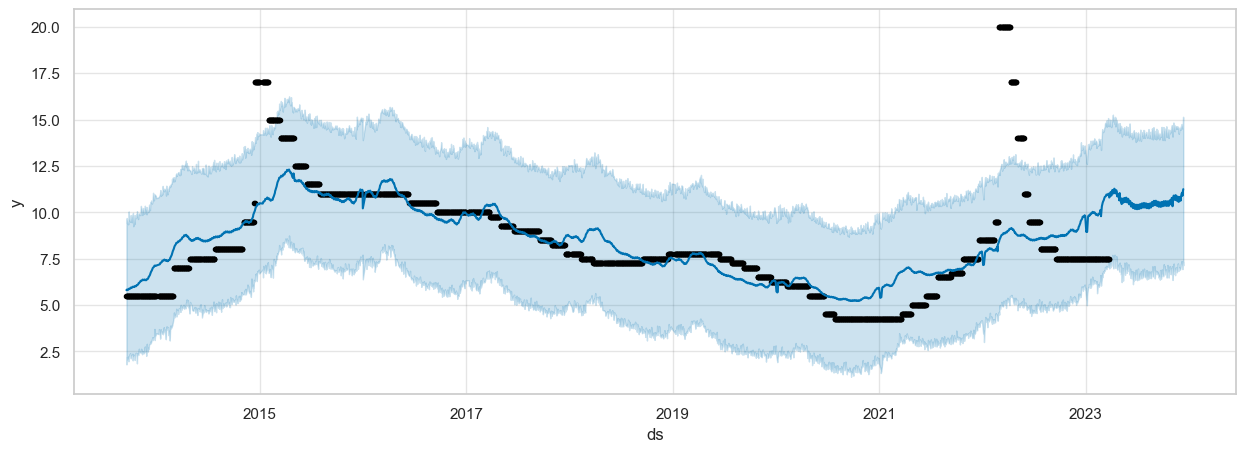

In [249]:
# смотрим график прогноза с праздниками
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = final_test_model.plot(forecast,ax=ax)
plt.show()

In [250]:
df_test_final = final_test_model.predict(df_test)
df_test_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
258,2024-04-01,13.162789,9.436005,16.839654
259,2024-04-02,13.205852,9.212232,16.962633
260,2024-04-03,13.282257,9.257790,16.938219
261,2024-04-04,13.275872,9.721055,16.810144
262,2024-04-05,13.289150,9.472052,17.035778


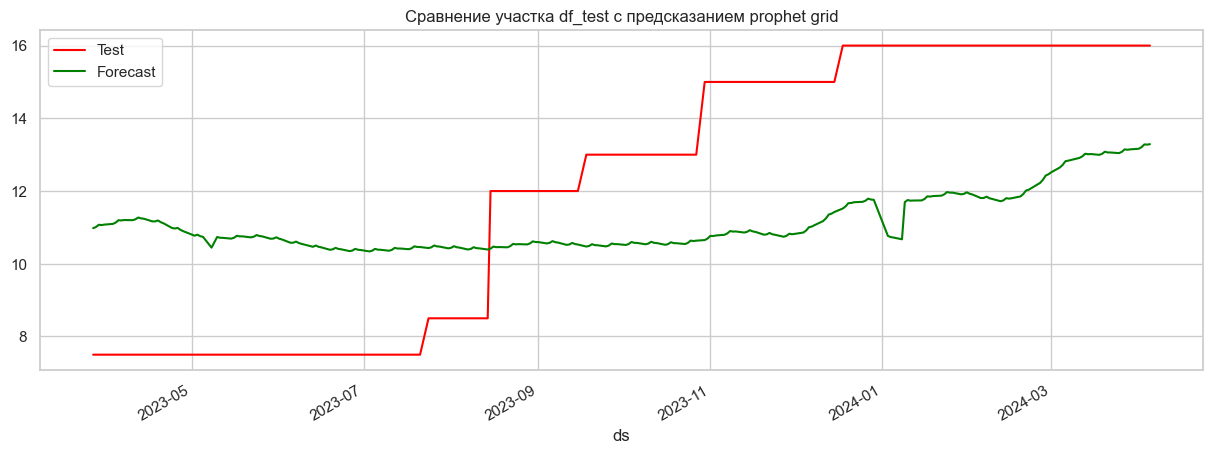

In [253]:
# сравнение участка df_test с предсказанием prophet grid
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_final.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet grid')
plt.show()

In [254]:
MAPE = mean_absolute_percentage_error(df_test['y'], abs(df_test_final['yhat']))
print('MAPE', MAPE)

MAPE 0.28570008661343704


In [243]:
# Сохранение DataFrame df в файл data/df.csv
df.to_csv('../data/df.csv', index=False)

# Сохранение DataFrame df_train в файл data/df_train.csv
df_train.to_csv('../data/df_train.csv', index=False)

# Сохранение DataFrame df_test в файл data/df_test.csv
df_test.to_csv('../data/df_test.csv', index=False)
